### 1. Load up datasets for 3 months
This project will be using the first quarter 2024 data. 

In [1]:
# Load parquet file into dataframe
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import dask.dataframe as dd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
import gc
from lightgbm import LGBMRegressor

Reuseable function to load required columns from parquet file

In [2]:
# Load file and ensure columns are in format to ease processing
def process_parquet(parquet_file_path):
    columns_needed = ['request_datetime', 'on_scene_datetime', 'PULocationID', 'DOLocationID', 'trip_time']
    
    # Read the specific columns
    df = pd.read_parquet(parquet_file_path, columns=columns_needed)
    
    # Convert datetime columns
    df['request_datetime'] = pd.to_datetime(df['request_datetime'])
    df['on_scene_datetime'] = pd.to_datetime(df['on_scene_datetime'])

    # Convert to second precision to save memory
    df['request_datetime'] = df['request_datetime'].values.astype('datetime64[s]')
    df['on_scene_datetime'] = df['on_scene_datetime'].values.astype('datetime64[s]')

    # Convert int64 to int32
    df['trip_time'] = df['trip_time'].astype('int32')
    
    # Calculate the wait_time in seconds
    df['wait_time'] = (df['on_scene_datetime'] - df['request_datetime']).dt.total_seconds()
    df['wait_time'] = df['wait_time'].astype('float32')
    
    return df

In [3]:
# Jan 2024
trip_jan = process_parquet('data/fhvhv_tripdata_2024-01.parquet')
trip_jan.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
0,2024-01-01 00:21:47,2024-01-01 00:25:06,161,158,2251,199.0
1,2024-01-01 00:10:56,2024-01-01 00:11:08,137,79,432,12.0
2,2024-01-01 00:20:04,2024-01-01 00:21:51,79,186,731,107.0
3,2024-01-01 00:35:46,2024-01-01 00:39:59,234,148,930,253.0
4,2024-01-01 00:48:19,2024-01-01 00:56:23,148,97,761,484.0


In [4]:
# Feb 2024
trip_feb = process_parquet('data/fhvhv_tripdata_2024-02.parquet') 
trip_feb.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
0,2024-02-01 00:13:55,2024-02-01 00:19:59,149,210,420,364.0
1,2024-02-01 00:00:14,2024-02-01 00:03:28,127,136,300,194.0
2,2024-02-01 00:13:57,2024-02-01 00:15:44,127,69,848,107.0
3,2024-02-01 00:40:21,NaT,169,169,541,NaN
4,2024-02-01 00:14:14,2024-02-01 00:15:55,142,152,658,101.0


In [5]:
# Mar 2024
trip_mar = process_parquet('data/fhvhv_tripdata_2024-03.parquet') 
trip_mar.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
0,2024-03-01 00:42:28,2024-03-01 00:45:18,148,144,170,170.0
1,2024-03-01 00:54:31,2024-03-01 00:55:55,79,114,291,84.0
2,2024-03-01 00:18:51,2024-03-01 00:20:27,232,148,425,96.0
3,2024-03-01 00:24:09,2024-03-01 00:30:33,148,233,766,384.0
4,2024-03-01 00:05:27,2024-03-01 00:07:42,48,237,1688,135.0


In [6]:
# Merge the three dataframes, ensure the merge is optimised
trips = pd.concat([trip_jan, trip_feb, trip_mar], ignore_index=True)

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time
0,2024-01-01 00:21:47,2024-01-01 00:25:06,161,158,2251,199.0
1,2024-01-01 00:10:56,2024-01-01 00:11:08,137,79,432,12.0
2,2024-01-01 00:20:04,2024-01-01 00:21:51,79,186,731,107.0
3,2024-01-01 00:35:46,2024-01-01 00:39:59,234,148,930,253.0
4,2024-01-01 00:48:19,2024-01-01 00:56:23,148,97,761,484.0


In [7]:
# For memory sakes, delete the unneeded dataframes
del trip_jan
del trip_feb
del trip_mar
gc.collect()

18

In [8]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60303866 entries, 0 to 60303865
Data columns (total 6 columns):
 #   Column             Dtype        
---  ------             -----        
 0   request_datetime   datetime64[s]
 1   on_scene_datetime  datetime64[s]
 2   PULocationID       int32        
 3   DOLocationID       int32        
 4   trip_time          int32        
 5   wait_time          float32      
dtypes: datetime64[s](2), float32(1), int32(3)
memory usage: 1.8 GB


### 2. Data Exploration
#### 2.1. Check for nulls

In [9]:
# Shape of dataframe
trips.shape

(60303866, 6)

In [10]:
# Check for nulls
trips.isnull().sum()

request_datetime            0
on_scene_datetime    15797599
PULocationID                0
DOLocationID                0
trip_time                   0
wait_time            15797599
dtype: int64

In [11]:
# Drop nulls there is more than enough data
trips = trips.dropna()
trips.shape

(44506267, 6)

#### 2.2 Check and Handle Outliers

In [12]:
# Check outliers for request_datetime
trips['request_datetime'].describe()

count               44506267
mean     2024-02-16 13:05:18
min      2023-12-31 23:18:00
25%      2024-01-25 08:20:55
50%      2024-02-16 17:26:09
75%      2024-03-09 19:50:00
max      2024-04-01 00:15:00
Name: request_datetime, dtype: object

In [13]:
# Check outliers for on_scene_datetime
trips['on_scene_datetime'].describe()

count               44506267
mean     2024-02-16 13:08:30
min      2023-12-31 22:55:22
25%      2024-01-25 08:24:34
50%      2024-02-16 17:29:28
75%      2024-03-09 19:56:37
max      2024-03-31 23:59:59
Name: on_scene_datetime, dtype: object

In [14]:
# Check outliers for trip_time
trips['trip_time'].describe()

count    4.450627e+07
mean     1.149332e+03
std      8.066760e+02
min      0.000000e+00
25%      5.820000e+02
50%      9.390000e+02
75%      1.485000e+03
max      5.206000e+04
Name: trip_time, dtype: float64

In [15]:
# Checking for trip times that are 0 or negative as the describe shows the min is 0
trips[trips['trip_time'] <= 0]['trip_time'].count()

7

In [16]:
# Deleting trips with 0 trip time as they never happened
trips = trips[trips['trip_time'] > 0]

In [17]:
# Check outliers for wait_time
trips['wait_time'].describe()

count    4.450626e+07
mean     1.914310e+02
std      1.915658e+02
min     -1.659800e+04
25%      9.600000e+01
50%      1.630000e+02
75%      2.580000e+02
max      3.919500e+04
Name: wait_time, dtype: float64

<Axes: xlabel='wait_time'>

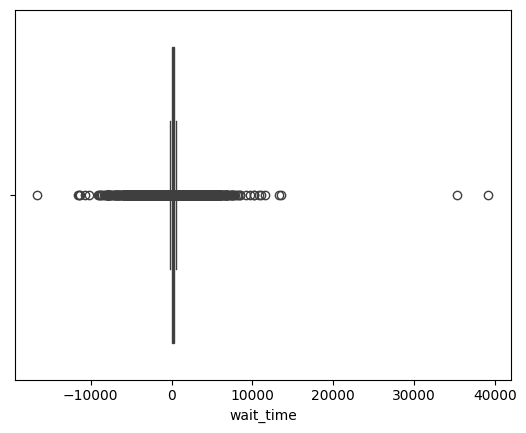

In [18]:
# Wait time seems to have some negative values from the min. Using boxplot to investigate more
sns.boxplot(x=trips['wait_time'])

In [19]:
# Get the count of negative wait times.
trips[trips['wait_time'] < 0]['wait_time'].count()

408505

In [20]:
# Drop negative wait times
trips = trips[trips['wait_time'] >= 0]

trips.shape

(44097755, 6)

In [21]:
# Check for outliers in location
trips['PULocationID'].describe()

count    4.409776e+07
mean     1.391295e+02
std      7.478673e+01
min      1.000000e+00
25%      7.600000e+01
50%      1.400000e+02
75%      2.110000e+02
max      2.650000e+02
Name: PULocationID, dtype: float64

In [22]:
trips['DOLocationID'].describe()

count    4.409776e+07
mean     1.425093e+02
std      7.777297e+01
min      1.000000e+00
25%      7.600000e+01
50%      1.420000e+02
75%      2.170000e+02
max      2.650000e+02
Name: DOLocationID, dtype: float64

### 3.0. Feature Selection (add external data)
#### 3.1. Add Holidays in NYC data

In [23]:
# Holidays
from datetime import date
import holidays

ny_holidays = holidays.country_holidays('US', subdiv='NY', years=2024)

# Load ny_holidays into dataframe, date and holiday name
ny_holidays_df = pd.DataFrame.from_dict(ny_holidays, orient='index')
ny_holidays_df

,0
2024-01-01,New Year's Day
2024-05-27,Memorial Day
2024-06-19,Juneteenth National Independence Day
2024-07-04,Independence Day
2024-09-02,Labor Day
2024-11-11,Veterans Day
2024-11-28,Thanksgiving
2024-12-25,Christmas Day
2024-01-15,Martin Luther King Jr. Day
2024-02-19,Washington's Birthday


In [24]:
# Reset index and rename columns
ny_holidays_df.reset_index(inplace=True)
ny_holidays_df.columns = ['date', 'holiday_name']
ny_holidays_df

,date,holiday_name
0,2024-01-01,New Year's Day
1,2024-05-27,Memorial Day
2,2024-06-19,Juneteenth National Independence Day
3,2024-07-04,Independence Day
4,2024-09-02,Labor Day
5,2024-11-11,Veterans Day
6,2024-11-28,Thanksgiving
7,2024-12-25,Christmas Day
8,2024-01-15,Martin Luther King Jr. Day
9,2024-02-19,Washington's Birthday


In [25]:
# Convert holidays to datetime and create is_holiday flag in the trips dataframe
ny_holidays_df.index = pd.to_datetime(ny_holidays_df.index)
ny_holidays_df['date'].values.astype('datetime64[s]')
trips['is_holiday'] = trips['request_datetime'].dt.date.isin(ny_holidays_df['date']).astype(int)
trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday
0,2024-01-01 00:21:47,2024-01-01 00:25:06,161,158,2251,199.0,1
1,2024-01-01 00:10:56,2024-01-01 00:11:08,137,79,432,12.0,1
2,2024-01-01 00:20:04,2024-01-01 00:21:51,79,186,731,107.0,1
3,2024-01-01 00:35:46,2024-01-01 00:39:59,234,148,930,253.0,1
4,2024-01-01 00:48:19,2024-01-01 00:56:23,148,97,761,484.0,1


In [26]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44097755 entries, 0 to 60303865
Data columns (total 7 columns):
 #   Column             Dtype        
---  ------             -----        
 0   request_datetime   datetime64[s]
 1   on_scene_datetime  datetime64[s]
 2   PULocationID       int32        
 3   DOLocationID       int32        
 4   trip_time          int32        
 5   wait_time          float32      
 6   is_holiday         int32        
dtypes: datetime64[s](2), float32(1), int32(4)
memory usage: 1.8 GB


#### 3.2. Add Time Based Features

In [27]:
# Hour of the day, day of the week, month, year
trips['hour'] = trips['request_datetime'].dt.hour
trips['week_day'] = trips['request_datetime'].dt.weekday
trips['month'] = trips['request_datetime'].dt.month

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month
0,2024-01-01 00:21:47,2024-01-01 00:25:06,161,158,2251,199.0,1,0,0,1
1,2024-01-01 00:10:56,2024-01-01 00:11:08,137,79,432,12.0,1,0,0,1
2,2024-01-01 00:20:04,2024-01-01 00:21:51,79,186,731,107.0,1,0,0,1
3,2024-01-01 00:35:46,2024-01-01 00:39:59,234,148,930,253.0,1,0,0,1
4,2024-01-01 00:48:19,2024-01-01 00:56:23,148,97,761,484.0,1,0,0,1


In [28]:
# Define total trip time
trips['total_trip_time'] = trips['wait_time'] + trips['trip_time']
trips['total_trip_time'] = trips['wait_time'].astype('float32')
trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month,total_trip_time
0,2024-01-01 00:21:47,2024-01-01 00:25:06,161,158,2251,199.0,1,0,0,1,199.0
1,2024-01-01 00:10:56,2024-01-01 00:11:08,137,79,432,12.0,1,0,0,1,12.0
2,2024-01-01 00:20:04,2024-01-01 00:21:51,79,186,731,107.0,1,0,0,1,107.0
3,2024-01-01 00:35:46,2024-01-01 00:39:59,234,148,930,253.0,1,0,0,1,253.0
4,2024-01-01 00:48:19,2024-01-01 00:56:23,148,97,761,484.0,1,0,0,1,484.0


In [29]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44097755 entries, 0 to 60303865
Data columns (total 11 columns):
 #   Column             Dtype        
---  ------             -----        
 0   request_datetime   datetime64[s]
 1   on_scene_datetime  datetime64[s]
 2   PULocationID       int32        
 3   DOLocationID       int32        
 4   trip_time          int32        
 5   wait_time          float32      
 6   is_holiday         int32        
 7   hour               int32        
 8   week_day           int32        
 9   month              int32        
 10  total_trip_time    float32      
dtypes: datetime64[s](2), float32(2), int32(7)
memory usage: 2.5 GB


#### 3.3. Group into Peak, off-peak and night time

In [30]:
""" 
    Group request datetime into Peak, Off-Peak and Night
    Night: 10pm to 6am
    Off-Peak: Weekdays, 10am to 3pm and 7pm to 10pm. Weekends, 6am to 10pm
    Peak: Weekdays, 6am to 10am and 3pm to 7pm
"""

# Extract hour and day of week
hour = trips['hour']
week_day = trips['week_day']

# is holiday
is_holiday = trips['is_holiday'].astype(bool)

# Initialize the default group as Night (0)
trips['request_time_group'] = 0

# Define conditions for Peak (2) and OffPeak (1) times for weekday
weekday_mask = week_day < 5

peak_mask = (hour >= 6) & (hour < 10) | (hour >= 15) & (hour < 19)
off_peak_mask = (hour >= 10) & (hour < 15) | (hour >= 19) & (hour < 22)

# For weekend
weekend_mask = ~weekday_mask

# Apply conditions for weekdays
# Pandas is built to work efficiently with data in a vectorized way, meaning it can operate on entire columns (or Series) of data at once without needing an explicit loop
# .loc leverages the underlying numpy array to apply the mask to the dataframe without iterating over rows one by one
# note that all day during holidays are Off-Peak

# If day is not holiday, it will be Peak
trips.loc[weekday_mask & peak_mask & ~is_holiday, 'request_time_group'] = 2
# If day is holiday, it will be Off-Peak
trips.loc[weekday_mask & peak_mask & is_holiday, 'request_time_group'] = 1

trips.loc[weekday_mask & off_peak_mask, 'request_time_group'] = 1

# Apply conditions for weekends
trips.loc[weekend_mask & (hour >= 6) & (hour < 22), 'request_time_group'] = 1

trips.head()

,request_datetime,on_scene_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month,total_trip_time,request_time_group
0,2024-01-01 00:21:47,2024-01-01 00:25:06,161,158,2251,199.0,1,0,0,1,199.0,0
1,2024-01-01 00:10:56,2024-01-01 00:11:08,137,79,432,12.0,1,0,0,1,12.0,0
2,2024-01-01 00:20:04,2024-01-01 00:21:51,79,186,731,107.0,1,0,0,1,107.0,0
3,2024-01-01 00:35:46,2024-01-01 00:39:59,234,148,930,253.0,1,0,0,1,253.0,0
4,2024-01-01 00:48:19,2024-01-01 00:56:23,148,97,761,484.0,1,0,0,1,484.0,0


In [31]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44097755 entries, 0 to 60303865
Data columns (total 12 columns):
 #   Column              Dtype        
---  ------              -----        
 0   request_datetime    datetime64[s]
 1   on_scene_datetime   datetime64[s]
 2   PULocationID        int32        
 3   DOLocationID        int32        
 4   trip_time           int32        
 5   wait_time           float32      
 6   is_holiday          int32        
 7   hour                int32        
 8   week_day            int32        
 9   month               int32        
 10  total_trip_time     float32      
 11  request_time_group  int64        
dtypes: datetime64[s](2), float32(2), int32(7), int64(1)
memory usage: 2.8 GB


In [32]:
# Drop unneeded columns
trips.drop(['on_scene_datetime'], axis=1, inplace=True)

trips.head()

,request_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month,total_trip_time,request_time_group
0,2024-01-01 00:21:47,161,158,2251,199.0,1,0,0,1,199.0,0
1,2024-01-01 00:10:56,137,79,432,12.0,1,0,0,1,12.0,0
2,2024-01-01 00:20:04,79,186,731,107.0,1,0,0,1,107.0,0
3,2024-01-01 00:35:46,234,148,930,253.0,1,0,0,1,253.0,0
4,2024-01-01 00:48:19,148,97,761,484.0,1,0,0,1,484.0,0


In [33]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44097755 entries, 0 to 60303865
Data columns (total 11 columns):
 #   Column              Dtype        
---  ------              -----        
 0   request_datetime    datetime64[s]
 1   PULocationID        int32        
 2   DOLocationID        int32        
 3   trip_time           int32        
 4   wait_time           float32      
 5   is_holiday          int32        
 6   hour                int32        
 7   week_day            int32        
 8   month               int32        
 9   total_trip_time     float32      
 10  request_time_group  int64        
dtypes: datetime64[s](1), float32(2), int32(7), int64(1)
memory usage: 2.5 GB


#### 3.4. NYC weather

In [34]:
# Get Weather data
from datetime import datetime 
from meteostat import Point, Hourly, units  
# Set time period 
start = datetime(2024, 1, 1) 
end = datetime(2024, 3, 31)  
# Create Point for NY
location = Point(40.712775, -74.005973)  
# Get daily data 
weather_data = Hourly(location, start, end) 
weather_data = weather_data.convert(units.imperial) 
weather_data = weather_data.fetch()

weather_data.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2024-01-01 00:00:00,42.8,28.6,57.0,0.0,NaN,260.0,6.8,NaN,1017.0,NaN,3.0
2024-01-01 01:00:00,42.1,27.9,57.0,0.0,NaN,260.0,7.0,NaN,1016.4,NaN,3.0
2024-01-01 02:00:00,42.1,28.8,59.0,0.0,NaN,260.0,5.8,NaN,1016.4,NaN,3.0
2024-01-01 03:00:00,42.1,30.0,62.0,0.0,NaN,250.0,5.8,NaN,1016.4,NaN,3.0
2024-01-01 04:00:00,42.1,30.7,64.0,0.0,NaN,260.0,5.8,NaN,1016.5,NaN,3.0


In [35]:
# Reset index and convert time to datetime
weather_data.reset_index(inplace=True)
weather_data.rename(columns={'index': 'time'}, inplace=True)
weather_data['time'] = pd.to_datetime(weather_data['time'])

weather_data.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2024-01-01 00:00:00,42.8,28.6,57.0,0.0,NaN,260.0,6.8,NaN,1017.0,NaN,3.0
1,2024-01-01 01:00:00,42.1,27.9,57.0,0.0,NaN,260.0,7.0,NaN,1016.4,NaN,3.0
2,2024-01-01 02:00:00,42.1,28.8,59.0,0.0,NaN,260.0,5.8,NaN,1016.4,NaN,3.0
3,2024-01-01 03:00:00,42.1,30.0,62.0,0.0,NaN,250.0,5.8,NaN,1016.4,NaN,3.0
4,2024-01-01 04:00:00,42.1,30.7,64.0,0.0,NaN,260.0,5.8,NaN,1016.5,NaN,3.0


In [36]:
# Create column to compare with weather time
trips['rounded_request_datetime'] = trips['request_datetime'].dt.round('H')

In [37]:
# Merge trips and weather dataframe on trips[rounded_request_datetime] and weather[time]
trips = trips.merge(weather_data, left_on='rounded_request_datetime', right_on='time', how='left')
trips.head()

,request_datetime,PULocationID,DOLocationID,trip_time,wait_time,is_holiday,hour,week_day,month,total_trip_time,...,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2024-01-01 00:21:47,161,158,2251,199.0,1,0,0,1,199.0,...,28.6,57.0,0.0,NaN,260.0,6.8,NaN,1017.0,NaN,3.0
1,2024-01-01 00:10:56,137,79,432,12.0,1,0,0,1,12.0,...,28.6,57.0,0.0,NaN,260.0,6.8,NaN,1017.0,NaN,3.0
2,2024-01-01 00:20:04,79,186,731,107.0,1,0,0,1,107.0,...,28.6,57.0,0.0,NaN,260.0,6.8,NaN,1017.0,NaN,3.0
3,2024-01-01 00:35:46,234,148,930,253.0,1,0,0,1,253.0,...,27.9,57.0,0.0,NaN,260.0,7.0,NaN,1016.4,NaN,3.0
4,2024-01-01 00:48:19,148,97,761,484.0,1,0,0,1,484.0,...,27.9,57.0,0.0,NaN,260.0,7.0,NaN,1016.4,NaN,3.0


In [38]:
# Remove unneeded columns
trips.drop(['request_datetime', 'rounded_request_datetime', 'trip_time', 'time', 'dwpt', 'rhum', 'wait_time', 'prcp','snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'temp'], axis=1, inplace=True)

In [39]:
# Change data types
trips['request_time_group'] = trips['request_time_group'].astype('int32')
trips['coco'] = trips['coco'].astype('float32')

# Rename coco to weather_condition_code  
trips.rename(columns={'coco': 'weather_condition_code'}, inplace=True)

In [40]:
# Keeping track of memory usage
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44097755 entries, 0 to 44097754
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   PULocationID            int32  
 1   DOLocationID            int32  
 2   is_holiday              int32  
 3   hour                    int32  
 4   week_day                int32  
 5   month                   int32  
 6   total_trip_time         float32
 7   request_time_group      int32  
 8   weather_condition_code  float32
dtypes: float32(2), int32(7)
memory usage: 1.5 GB


In [41]:
# Deleting the unneeded dataframes
del weather_data
del ny_holidays_df
del ny_holidays
gc.collect()

45

In [42]:
# Check for null values
trips.isnull().sum()

PULocationID                   0
DOLocationID                   0
is_holiday                     0
hour                           0
week_day                       0
month                          0
total_trip_time                0
request_time_group             0
weather_condition_code    465278
dtype: int64

In [43]:
# Drop null values
trips.dropna(inplace=True)

In [44]:
# Check for null values
trips.isnull().sum()

PULocationID              0
DOLocationID              0
is_holiday                0
hour                      0
week_day                  0
month                     0
total_trip_time           0
request_time_group        0
weather_condition_code    0
dtype: int64

In [45]:
# Check dataset shape
trips.shape

(43632477, 9)

### 4.0. Correlation Analysis

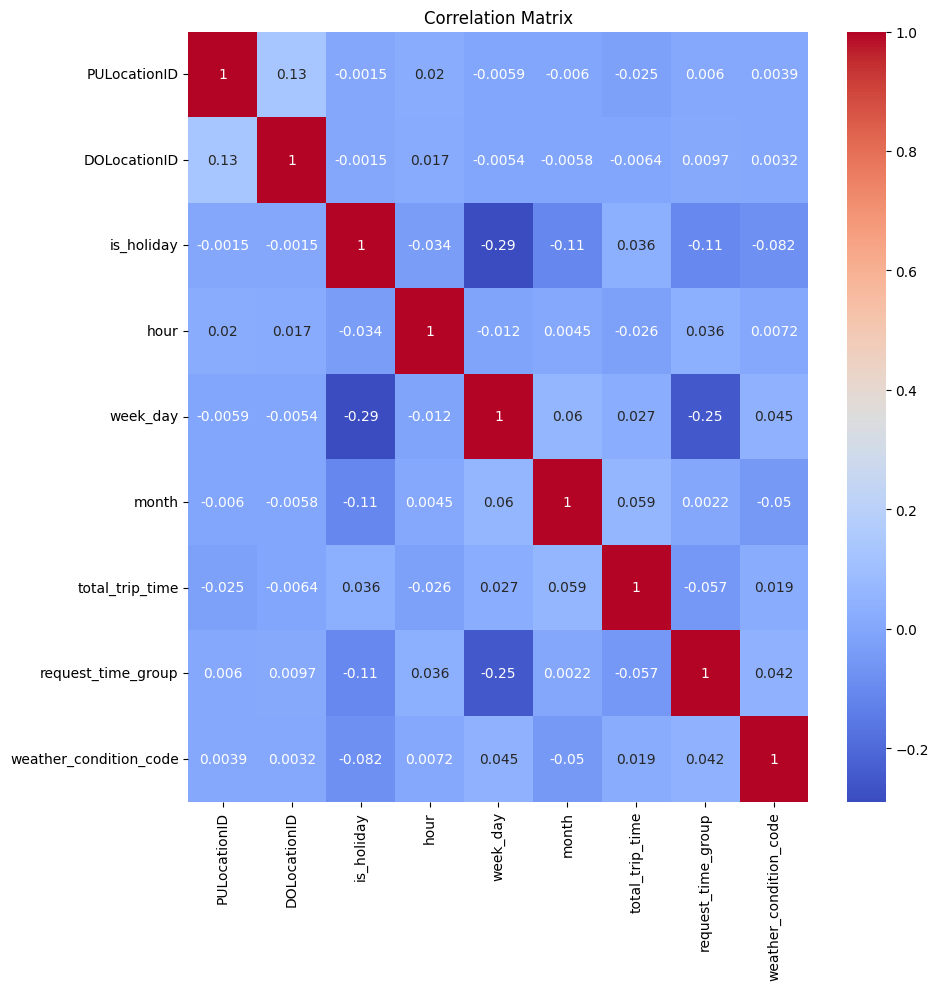

In [46]:
#correlation heatmap, to check correlation between different variables
#results range from -1 to 1 where 1 is perfect correlation and -1 is perfect negative correlation
correlation_matrix = trips.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

In [47]:
trips.head()

,PULocationID,DOLocationID,is_holiday,hour,week_day,month,total_trip_time,request_time_group,weather_condition_code
0,161,158,1,0,0,1,199.0,0,3.0
1,137,79,1,0,0,1,12.0,0,3.0
2,79,186,1,0,0,1,107.0,0,3.0
3,234,148,1,0,0,1,253.0,0,3.0
4,148,97,1,0,0,1,484.0,0,3.0


In [48]:
#rounding up columns ans converting to int32
trips['total_trip_time'] = np.ceil(trips['total_trip_time']).astype('int32')
trips['weather_condition_code'] = np.ceil(trips['weather_condition_code']).astype('int32')

trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43632477 entries, 0 to 43661929
Data columns (total 9 columns):
 #   Column                  Dtype
---  ------                  -----
 0   PULocationID            int32
 1   DOLocationID            int32
 2   is_holiday              int32
 3   hour                    int32
 4   week_day                int32
 5   month                   int32
 6   total_trip_time         int32
 7   request_time_group      int32
 8   weather_condition_code  int32
dtypes: int32(9)
memory usage: 1.8 GB


### 5.0 Machine Learning Models
#### 5.1 Linear Regression

In [49]:
""" 
From the correlation Matrix, there is a low correlation/weak linear relationship between total_trip_time and the other variables. This suggest the use of complex models to capture the non-linear relationship.

Starting with a simple linear regression model, even though the correlation is low, the model is able to give a baseline comparison.
"""

# Define features and target
X = trips.drop('total_trip_time', axis=1)
y = trips['total_trip_time']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


Mean Absolute Error: 109.94570548815182
Mean Squared Error: 24652.717071493695
R-squared: 0.010479733332054875


In [50]:
#save model to pickle
import pickle

pickle.dump(lr_model, open('lr_model.pkl', 'wb'))


#### 5.2. Random Forest

In [51]:
# RF can capture complex non-linear relationships
# Random Forest Regression
rf_model = RandomForestRegressor(max_depth=2, random_state=0)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Absolute Error: 109.27799369123908
Mean Squared Error: 24366.378251061375
R-squared: 0.021972911350927382


#### 5.3. LightGBM

In [52]:
# LGBM can capture complex non-linear relationships
# LightGBM Regression
lgbm_model = LGBMRegressor(random_state=0)
lgbm_model.fit(X_train, y_train)

# Make predictions
y_pred = lgbm_model.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.522827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 483
[LightGBM] [Info] Number of data points in the train set: 34905981, number of used features: 8
[LightGBM] [Info] Start training from score 200.769396
Mean Absolute Error: 102.25610552647763
Mean Squared Error: 21603.89202691343
R-squared: 0.132854648940259


#### 5.4. SVM

In [53]:
# SVM can capture complex non-linear relationships
# Support Vector Regression

#standardize the data
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train)
X_test1 = sc.transform(X_test)

#create the model
svm = svm.SVC(kernel = 'rbf')
svm.fit(X_train1, y_train)

#predict on the train set and test set
y_train_pred = svm.predict(X_train1)
y_test_pred = svm.predict(X_test1)

#evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))